# PPO Algorithm
In this notebook, you'll code The PPO Algorithm from scratch: .

PPO algorithm is a *Policy-based method* that aims to reduce the variance of the Reinforce algorithm and train our agent faster and better by using a combination of Policy-Based and Value-Based methods


To test its robustness, we're going to train it in Cartpole-v1 environment

## Import the packages

In [1]:
import numpy as np
import pandas as pd
from collections import deque
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

# Gym
import gymnasium as gym

## Check if we have a GPU
- Let's check if we have a GPU `device:cuda0`

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cpu')

# Agent: Playing CartPole-v1 🤖
### The CartPole-v1 environment

> A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart.

So, we start with CartPole-v1. The goal is to push the cart left or right **so that the pole stays in the equilibrium.**

The episode ends if:
- The pole Angle is greater than ±12°
- Cart Position is greater than ±2.4
- Episode length is greater than 500

We get a reward 💰 of +1 every timestep the Pole stays in the equilibrium.

In [4]:
env_id = "CartPole-v1"
#env_id="LunarLander-v2"
# Create the env
env = gym.make(env_id)


# Get the state space and action space
s_size = env.observation_space.shape[0]
a_size = env.action_space.n

## Let's build the PPO algo

In [5]:
#Using a neural network to learn our actor (policy) parameters

class Actor(nn.Module):
    def __init__(self, s_size, a_size, h_size):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=-1)

    def act(self, state):
        probs = self.forward(state)
        m = Categorical(probs)
        action = m.sample()
        return action, m.log_prob(action)

In [6]:
class Critic(nn.Module):
    def __init__(self, s_size, h_size):
        super(Critic, self).__init__()
        self.input_layer = nn.Linear(s_size, h_size)
        self.output_layer = nn.Linear(h_size, 1)

    def forward(self, x):
        x = self.input_layer(x)
        x = F.relu(x)
        state_value = self.output_layer(x)
        return state_value

# Building the parts of our algorithm #
The main steps for building a PPO Algo are:
1. Generates a trajectory
2. Compute the discounted returns
3. Standardization of the returns
4. PPO Update
5. PPO train


In [7]:
def generate_trajectory_ppo(actor, critic, max_t):
    saved_log_probs = []
    rewards = []
    state_values = []

    #new
    saved_states = []
    saved_actions = []

    state = env.reset()[0]

    for t in range(max_t):
        # Convert state to tensor and add to memory
        state = torch.from_numpy(state).float().to(device)

        action, log_prob =  actor.act(state.unsqueeze(0))

        # Get value from critic
        state_val = critic.forward(state.unsqueeze(0))

        # Step environment
        next_state, reward, done, _, _ = env.step(action.item())

        # The the current state, selected action, log_prob, reward and state_val
        # -----------------add code here-----------------
        saved_states.append(state)
        saved_actions.append(action)
        saved_log_probs.append(log_prob)
        rewards.append(reward)
        state_values.append(state_val)

        state = next_state

        if done:
            break
    return saved_states, saved_actions, saved_log_probs, rewards, state_values

In [8]:
def computer_cumulative_reward(rewards, max_t,gamma):
  returns = deque(maxlen=max_t)
  n_steps = len(rewards)
  for t in range(n_steps)[::-1]:
    disc_return_t = (returns[0] if len(returns)>0 else 0)
    returns.appendleft( rewards[t]+gamma*disc_return_t)
  return returns

In [9]:
def returns_standardization(returns):
        eps = np.finfo(np.float32).eps.item()
        ## eps is the smallest representable float, which is
        # added to the standard deviation of the returns to avoid numerical instabilities
        returns = torch.tensor(returns).to(device)
        returns = (returns - returns.mean()) / (returns.std() + eps)

        return returns

In [10]:
def ppo_update(actor, critic, actor_opt, critic_opt, states, actions, old_log_probs, returns, advantages, eps_clip, K_epochs):

    # 1. Convert lists to tensors for batch processing
    states = torch.stack(states).detach()
    actions = torch.stack(actions).detach().squeeze()
    old_log_probs = torch.stack(old_log_probs).detach().squeeze()
    advantages = advantages.detach()

    # Optimize policy for K epochs
    for _ in range(K_epochs):

        # --- Evaluation ---
        # Pass ALL states through the actor again to get CURRENT probabilities
        probs = actor(states)
        dist = Categorical(probs)

        # Get current log probs of the actions we took previously
        new_log_probs = dist.log_prob(actions)


        # Get current State Values from Critic
        state_values = critic(states).squeeze()

        # --- PPO Ratio Calculation ---
        # Ratio = exp(log(new) - log(old))
        ratios = torch.exp(new_log_probs - old_log_probs)

        # --- Surrogate Loss ---
        surr1 = ratios * advantages
        surr2 = torch.clamp(ratios, 1-eps_clip, 1+eps_clip) * advantages

        # Actor Loss: Negative minimum of surrogates (Maximize objective)
        loss_actor = -torch.min(surr1, surr2).mean()

        # Calculate Entropy (useful to encourage exploration)
        # Actor Loss: Negative minimum of surrogates (Maximize objective) - Entropy Bonus
        dist_entropy = dist.entropy()
        loss_actor= loss_actor-0.01 * dist_entropy.mean()

        # Critic Loss: MSE between new state values and actual returns
        loss_critic = F.mse_loss(state_values, returns)

        # --- Update Steps ---
        actor_opt.zero_grad()
        loss_actor.backward()
        actor_opt.step()

        critic_opt.zero_grad()
        loss_critic.backward()
        critic_opt.step()

## Merge all functions into the PPo method ##

You will now see how the overall **PPo Algo** is structured by putting together all the building blocks (functions implemented in the previous parts) together, in the right order.

In [11]:
def PPO_Train(actor, critic, actor_opt, critic_opt, n_episodes, max_t, gamma, eps_clip,K_epochs,print_every):
    scores_deque = deque(maxlen=100)
    scores = []


    for i_episode in range(1, n_episodes + 1):

        # 1. Generate Trajectory
        states, actions, log_probs, rewards, state_values = generate_trajectory_ppo(actor, critic, max_t)

        # Track score
        current_score = sum(rewards)
        scores_deque.append(current_score)
        scores.append(current_score)

        # 2. Compute Returns and Advantages
        # calculate the return
        returns= computer_cumulative_reward(rewards,max_t,gamma)

        ## standardization of the returns is employed to make training more stable
        returns=returns_standardization(returns)


        # Advantages = Returns - Baseline (State Values)
        # We perform Advantage Normalization for stability
        state_values_tensor = torch.stack(state_values).squeeze().detach()

        # -----------------add code here-----------------
        advantages = returns - state_values_tensor
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-7)

        # 3. PPO Update
        ppo_update(actor, critic, actor_opt, critic_opt,
                   states, actions, log_probs, returns, advantages,
                   eps_clip, K_epochs)

        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))


    return scores

##  Train it
- We're now ready to train our agent.
- But first, we define a variable containing all the training hyperparameters.
- You can change the training parameters (and should 😉)

In [12]:
cartpole_hyperparameters = {
    "h_size": 64,
    "n_training_episodes": 1000,
    "n_evaluation_episodes": 10,
    "max_t": 1000,
    "gamma": 0.99,
    "lr": 1e-3,
    "env_id": env_id,
    "state_space": s_size,
    "action_space": a_size,
    "eps_clip": 0.2,     # PPO Clipping range (usually 0.1 to 0.2)
    "K_epochs": 4        # Number of optimization passes per batch
}

In [13]:
# Create actor and place it to the device
cartpole_actor =Actor(cartpole_hyperparameters["state_space"], cartpole_hyperparameters["action_space"], cartpole_hyperparameters["h_size"]).to(device)

cartpole_actorOptimizer =optim.Adam(cartpole_actor.parameters(), lr=cartpole_hyperparameters["lr"])

In [14]:
# Create critic and place it to the device
cartpole_critic =Critic(cartpole_hyperparameters["state_space"], cartpole_hyperparameters["h_size"]).to(device)
cartpole_criticOptimizer =optim.Adam(cartpole_critic.parameters(), lr=cartpole_hyperparameters["lr"])

In [16]:
scores = PPO_Train(cartpole_actor,
                   cartpole_critic,cartpole_actorOptimizer,cartpole_criticOptimizer,
                   cartpole_hyperparameters["n_training_episodes"],
                   cartpole_hyperparameters["max_t"],
                   cartpole_hyperparameters["gamma"],
                   cartpole_hyperparameters["eps_clip"],
                   cartpole_hyperparameters["K_epochs"],
                   50)

Episode 50	Average Score: 170.24
Episode 100	Average Score: 320.56
Episode 150	Average Score: 649.02
Episode 200	Average Score: 873.60
Episode 250	Average Score: 846.27
Episode 300	Average Score: 883.75
Episode 350	Average Score: 991.93
Episode 400	Average Score: 972.51
Episode 450	Average Score: 977.79
Episode 500	Average Score: 995.35
Episode 550	Average Score: 988.76
Episode 600	Average Score: 944.86
Episode 650	Average Score: 939.54
Episode 700	Average Score: 973.90
Episode 750	Average Score: 978.33
Episode 800	Average Score: 985.75
Episode 850	Average Score: 971.78
Episode 900	Average Score: 976.61
Episode 950	Average Score: 984.23
Episode 1000	Average Score: 965.32


In [17]:
scores= pd.Series(scores, name="scores_Actor")
scores.describe()

count    1000.000000
mean      889.221000
std       261.546318
min        23.000000
25%      1000.000000
50%      1000.000000
75%      1000.000000
max      1000.000000
Name: scores_Actor, dtype: float64

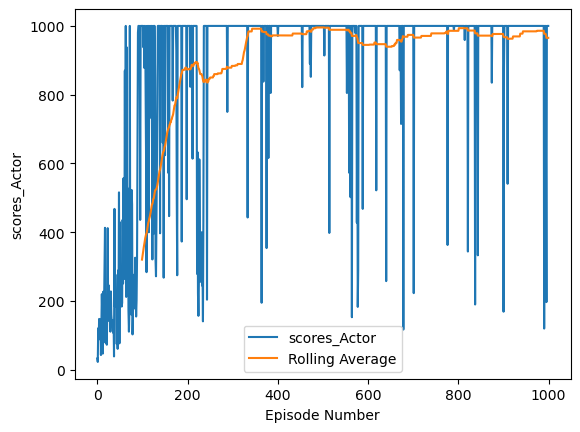

In [18]:
fig, ax = plt.subplots(1, 1)
_ = scores.plot(ax=ax, label="scores_Actor")
_ = (scores.rolling(window=100)
           .mean()
           .rename("Rolling Average")
           .plot(ax=ax))
ax.legend()
_ = ax.set_xlabel("Episode Number")
_ = ax.set_ylabel("scores_Actor")